In [1]:
from pygmo import hypervolume
import csv
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#### Modified from Pau's code
def compute_pareto_front(population):
    #print(np.shape(np.array(population)))
    #print(population)
    pop_size = len(population)
    obj_num = 2

    domination_counter = [0] * pop_size

    for i in range(pop_size):
        for j in range(i+1, pop_size):
            # check each objective for dominance
            dominate = [0] * obj_num
            for k in range(obj_num):
                if population[i][k] > population[j][k]:
                    dominate[k] = 1
                elif population[i][k] < population[j][k]:
                    dominate[k] = -1
            if -1 not in dominate and 1 in dominate:
                domination_counter[i] += 1
            elif -1 in dominate and 1 not in dominate:
                domination_counter[j] += 1

    pareto_solutions = []
    for i in range(len(domination_counter)):
        if domination_counter[i] == 0:
            pareto_solutions.append(population[i])
    return pareto_solutions

def compute_hv(population):
    array_archs = np.zeros((len(population), 2))
    for i in range(len(population)):
        array_archs[i] = population[i]
    hv_object = hypervolume(array_archs)
    hv = hv_object.compute([1.1,1.1])/1.1**2
    return hv

In [3]:
#### Read data from the appropriate csv file
np.set_printoptions(threshold=np.inf)

# set to: true - to read results for fibre stiffness model run
#         false - to read results for truss model run
fibre_stiffness = True

# set to: true - if Epsilon MOEA was used
#         false - if AOS MOEA was used
eps_moea = True

# set to: true - if biased initialization is used
#         false - if random initialization is used
biased_init = True

run_number = 1 # starts from 0

filepath = 'C:\\SEAK Lab\\SEAK Lab Github\\KD3M3\\Truss_AOS\\result\\'
if eps_moea:
    fileloc = 'Epsilon MOEA Runs\\'
    if fibre_stiffness:
        filename_model = 'Fibre Stiffness code run results\\'
        if biased_init:
            filename = 'Biased Initialization\\EpsilonMOEA_emoea' + str(run_number) + '_biasedinit_fibrestiffness_fullpop.csv'
        else:
            filename = 'Random Initialization\\EpsilonMOEA_emoea' + str(run_number) + '_fibrestiffness_fullpop.csv'
    else: 
        filename_model = 'Truss code run results\\'
        if biased_init:
            filename = 'Biased Initialization\\EpsilonMOEA_emoea' + str(run_number) + '_biasedinit_trussstiffness_fullpop.csv'
        else:
            filename = 'Random Initialization\\EpsilonMOEA_emoea' + str(run_number) + '_trussstiffness_fullpop.csv'            
else:
    fileloc = 'AOS MOEA Runs\\'
    if fibre_stiffness:
        filename = 'Feas and Stab False\\Fibre Stiffness code run results\\AOSMOEA_constraint_adaptive' + str(run_number) + '_fibrestiffness_fullpop.csv'
    else: 
        filename = 'Feas and Stab False\\Truss code run results\\AOSMOEA_constraint_adaptive' + str(run_number) + '_trussstiffness_fullpop.csv' 
    filename = ''

full_filepath = filepath + fileloc + filename_model + filename

with open(full_filepath,newline='') as csvfile:
    data = [row for row in csv.reader(csvfile)]
    designs = ["" for x in range(len(data)-1)]
    num_func_evals = np.zeros(len(data)-1)
    pen_obj1 = np.zeros(len(data)-1)
    pen_obj2 = np.zeros(len(data)-1)
    feas_scores = np.zeros(len(data)-1)
    stab_scores = np.zeros(len(data)-1)
    for x in range(len(data)-1):
        designs[x] = data[x+1][0]
        num_func_evals[x] = int(data[x+1][1])
        pen_obj1[x] = float(data[x+1][2])
        pen_obj2[x] = float(data[x+1][3])
        feas_scores[x] = float(data[x+1][4])
        stab_scores[x] = float(data[x+1][5])
        
n_des = len(designs)
des_array = np.zeros((n_des,36))
for x in range(n_des):
    current_des = designs[x]
    for y in range(36):
        des_array[x][y] = int(current_des[y])
        
#des_list = list(designs)

In [4]:
#### Compute true objectives
def compute_true_objectives(pen_obj1, pen_obj2, feas_score, stab_score, fib_stiff):
    pen_fac = 1
    if fib_stiff:
        pen_fac = 1.5
    pen = (np.log10(np.absolute(feas_score)) + np.log10(np.absolute(stab_score)))/2
    obj1 = 15*(pen_obj1 + pen_fac*pen)
    obj2 = -8500*(pen_obj2 + pen_fac*pen)
    return obj1, obj2

obj1_true = np.zeros(n_des)
obj2_true = np.zeros(n_des)
for i in range(n_des):
    obj1_true_current, obj2_true_current = compute_true_objectives(pen_obj1[i], pen_obj2[i], feas_scores[i], stab_scores[i], fibre_stiffness)
    obj1_true[i] = obj1_true_current
    obj2_true[i] = obj2_true_current

In [5]:
#### Sort num_fun_evals (and obj1 & obj2) in ascending order
n_func_evals = num_func_evals
sort_indices = np.argsort(n_func_evals)
pen_obj1_sorted = list(pen_obj1[sort_indices])
pen_obj2_sorted = list(pen_obj2[sort_indices])
feas_scores_sorted = list(feas_scores[sort_indices])
stab_scores_sorted = list(stab_scores[sort_indices])
true_obj1_sorted = list(obj1_true[sort_indices])
true_obj2_sorted = list(obj2_true[sort_indices])

designs_sorted = []
for i in range(len(sort_indices)):
    designs_sorted.append(designs[sort_indices[i]])

pen_obj1_max_fullrun = np.max(pen_obj1_sorted)
pen_obj1_min_fullrun = np.min(pen_obj1_sorted)
pen_obj2_max_fullrun = np.max(pen_obj2_sorted)
pen_obj2_min_fullrun = np.min(pen_obj2_sorted)

pen_objs_maxmin = np.zeros((2,2))
pen_objs_maxmin[0][0] = pen_obj1_max_fullrun
pen_objs_maxmin[0][1] = pen_obj1_min_fullrun
pen_objs_maxmin[1][0] = pen_obj2_max_fullrun
pen_objs_maxmin[1][1] = pen_obj2_min_fullrun

print('Penalized objectives maximum and minimum values for current run')

print(pen_obj1_max_fullrun)
print(pen_obj1_min_fullrun)
print(pen_obj2_max_fullrun)
print(pen_obj2_min_fullrun)

true_obj1_max_fullrun = np.max(true_obj1_sorted)
true_obj1_min_fullrun = np.min(true_obj1_sorted)
true_obj2_max_fullrun = np.max(true_obj2_sorted)
true_obj2_min_fullrun = np.min(true_obj2_sorted)

true_objs_maxmin = np.zeros((2,2))
true_objs_maxmin[0][0] = true_obj1_max_fullrun
true_objs_maxmin[0][1] = true_obj1_min_fullrun
true_objs_maxmin[1][0] = true_obj2_max_fullrun
true_objs_maxmin[1][1] = true_obj2_min_fullrun

print('True objectives maximum and minimum values for current run')

print(true_obj1_max_fullrun)
print(true_obj1_min_fullrun)
print(true_obj2_max_fullrun)
print(true_obj2_min_fullrun)

#print(n_func_evals)
#nfe_list = list(n_func_evals)
#nfe_list.sort()
#print(nfe_list)
#print(obj1_sorted)
#print(obj2_sorted)

nfe_list_sorted = list(n_func_evals[sort_indices])
#print(nfe_list)

Penalized objectives maximum and minimum values for current run
12.24202659325965
0.0
11.817197775530282
-0.914710810471064
True objectives maximum and minimum values for current run
59.7213595499958
0.0
8099.689437998484
143.42806945451443


In [6]:
#### Compute and plot hypervolume values
max_func_evals = nfe_list_sorted[-1]
ref_point = [1.1,1.1]

def get_feasibility_score(feas_array, index):
    return feas_array[index]

def get_stability_score(stab_array, index):
    return stab_array[index]

def get_true_objectives(obj1_true, obj2_true, index):
    return obj1_true[index], obj2_true[index]

def get_design(design_array, index):
    return design_array[index]

def find_last_index(val,search_list):
    for i in range(len(search_list)-1,-1,-1):
        if search_list[i] == val:
            last_index = i
            break
    return last_index

def find_last_index2(val,search_list):
    return len(search_list) - search_list[::-1].index(val) - 1

def find_closest_index(val,search_list):
    val_diff = np.array(search_list) - val
    #print(val_diff[510:520])
    closest_index = np.argmin(np.abs(val_diff))
    #print(closest_index)
    return closest_index

def rectify_objectives(objs1_sorted, objs2_sorted, num_evals_list, val, maxmin_pen_objs, maxmin_true_objs):
    obj1_max_overall = maxmin_pen_objs[0][0]
    obj1_min_overall = maxmin_pen_objs[0][1]
    obj2_max_overall = maxmin_pen_objs[1][0]
    obj2_min_overall = maxmin_pen_objs[1][1]
    
    true_obj1_max_overall = maxmin_true_objs[0][0]
    true_obj1_min_overall = maxmin_true_objs[0][1]
    true_obj2_max_overall = maxmin_true_objs[1][0]
    true_obj2_min_overall = maxmin_true_objs[1][1]
    
    objs = []
    objs_true = []
    #print(val)
    if val==0.0:
        n_eval_ind_last = find_last_index2(val, num_evals_list)
    else:
        n_eval_ind_last = find_closest_index(val, num_evals_list)
    
    #print('n_eval_ind_last = ' + str(n_eval_ind_last))
    
    obj1_current = objs1_sorted[:n_eval_ind_last]
    obj2_current = objs2_sorted[:n_eval_ind_last]
    n_total = len(obj1_current)
    
    ## Determining the pareto front from the current population
    pop_current = list(zip(obj1_current,obj2_current))
    pareto_current = compute_pareto_front(pop_current)
    pareto_current_unique = list(set(pareto_current))
    print('pareto front of the current population')
    print(pareto_current_unique)
    feas_array_pareto = []
    stab_array_pareto = []
    true_obj_pareto = []
    designs_pareto = []
    for pareto_obj_array in pareto_current_unique:
        pareto_index = objs1_sorted.index(pareto_obj_array[0])
        #pareto_index2 = objs2_sorted.index(pareto_obj_array[1])
        #print('pareto_indices')
        #print(pareto_index)
        #print(pareto_index2)
        feas_pareto = get_feasibility_score(feas_scores_sorted, pareto_index)
        stab_pareto = get_stability_score(stab_scores_sorted, pareto_index)
        feas_array_pareto.append(feas_pareto)
        stab_array_pareto.append(stab_pareto)
        #print(pareto_obj_array)
        #print(feas_pareto)
        #print(stab_pareto)
        
        obj1_true, obj2_true = compute_true_objectives(pareto_obj_array[0], pareto_obj_array[1], feas_pareto, stab_pareto, fibre_stiffness)
        #obj1_true, obj2_true = get_true_objectives(true_obj1_sorted, true_obj2_sorted, pareto_index)
        true_obj_pareto.append([obj1_true, obj2_true])
        designs_pareto.append(get_design(designs_sorted, pareto_index))
    print('feasibility score(s)')
    print(feas_array_pareto)
    print('stability score(s)')
    print(stab_array_pareto)
    print('true objective value(s)')
    print(true_obj_pareto)
    print('designs')
    print(designs_pareto)
        
    ## Normalizing both objectives, second objective is normalized so the max negative value is 0
    n_pareto_all = len(pareto_current)
    n_pareto = len(pareto_current_unique)
    obj1_pareto = [objs[0] for objs in pareto_current_unique]
    obj2_pareto = [objs[1] for objs in pareto_current_unique]
    
    obj1_rectified = np.zeros(n_pareto)
    obj2_rectified = np.zeros(n_pareto)
    
    true_obj1_pareto = [objs[0] for objs in true_obj_pareto]
    true_obj2_pareto = [objs[1] for objs in true_obj_pareto]
    
    true_obj1_rectified = np.zeros(n_pareto)
    true_obj2_rectified = np.zeros(n_pareto)
    
    for i in range(n_pareto):
        obj1_rectified[i] = (obj1_pareto[i] - obj1_min_overall)/(obj1_max_overall - obj1_min_overall)
        obj2_rectified[i] = (obj2_pareto[i] - obj2_min_overall)/(obj2_max_overall - obj2_min_overall)
        objs.insert(i, [obj1_rectified[i], obj2_rectified[i]])
        
        true_obj1_rectified[i] = (true_obj1_pareto[i] - true_obj1_min_overall)/(true_obj1_max_overall - true_obj1_min_overall)
        true_obj2_rectified[i] = (true_obj2_max_overall - true_obj2_pareto[i])/(true_obj2_max_overall - true_obj2_min_overall)
        objs_true.insert(i, [true_obj1_rectified[i], true_obj2_rectified[i]])
        
    #obj1_rect_list = list(obj1_rectified)
    #obj2_rect_list = list(obj2_rectified)
    
    #print('Normalized Objectives')
    #print(obj1_rect_list)
    #print(obj2_rect_list)
    
    return objs, objs_true, n_pareto, n_pareto_all, n_total

### PENALIZED OBJECTIVES HYPERVOLUME COMPUTATION

print('Starting hypervolume computation for penalized objectives')
pop_size = int(find_last_index2(0, nfe_list_sorted))
n_iter_jump = 50
n_iter = math.floor(max_func_evals/n_iter_jump)
hypervols = np.zeros(n_iter+1)
hypervols_true = np.zeros(n_iter+1)
nfe_array = np.zeros(n_iter+1)
n_pareto_archs = np.zeros(n_iter+1)
n_pareto_all_archs = np.zeros(n_iter+1)
n_total_archs = np.zeros(n_iter+1)
objs0, objs_true0, n_pareto_0, n_pareto_all_0, n_total_0 = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, nfe_list_sorted, 0.0, pen_objs_maxmin, true_objs_maxmin)
n_pareto_archs[0] = n_pareto_0
n_pareto_all_archs[0] = n_pareto_all_0
n_total_archs[0] = n_total_0
hv = hypervolume(objs0)
hypervols[0] = hv.compute(ref_point)/1.1**2
hv_true = hypervolume(objs_true0)
hypervols_true[0] = hv_true.compute(ref_point)/1.1**2
print('hypervolume')
print(hypervols[0])
print('true objectives hypervolume')
print(hypervols_true[0])
print('\n')
objs = [] 

print('Starting loop')
count = 1
for i in range(pop_size, int(max_func_evals), n_iter_jump):
    #n_eval_ind_last = find_last_index(math.floor((max_func_evals/10)*(i)), nfe_list)
    print('iter = ' + str(i))
    
    objs_i, objs_truei, n_pareto_i, n_pareto_all_i, n_total_i = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, nfe_list_sorted, i, pen_objs_maxmin, true_objs_maxmin)
    print('hypervolume objectives')
    print(objs_i)
    n_pareto_archs[count] = n_pareto_i
    n_total_archs[count] = n_total_i
    n_pareto_all_archs[count] = n_pareto_all_i
    hv = hypervolume(objs_i)
    hypervols[count] = hv.compute(ref_point)/1.1**2
    hv_true = hypervolume(objs_truei)
    hypervols_true[count] = hv_true.compute(ref_point)/1.1**2
    print('hypervolume')
    print(hypervols[count])
    print('true objectives hypervolume')
    print(hypervols_true[count])
    print('\n')
    nfe_array[count] = i
    count += 1
    
objs_last, objs_truelast, n_pareto_last, n_pareto_all_last, n_total_last = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, nfe_list_sorted, max_func_evals, pen_objs_maxmin, true_objs_maxmin)
n_pareto_archs[-1] = n_pareto_last
n_pareto_all_archs[-1] = n_pareto_all_last
n_total_archs[-1] = n_total_last
hv = hypervolume(objs_last)
hypervols[-1] = hv.compute(ref_point)/1.1**2
hv_true = hypervolume(objs_truelast)
hypervols_true[-1] = hv_true.compute(ref_point)/1.1**2
print('hypervolume')
print(hypervols[-1])
print('true objectives hypervolume')
print(hypervols_true[-1])
print('\n')
nfe_array[-1] = max_func_evals

#print(np.max(objs_last[:,1]))

Starting hypervolume computation for penalized objectives
pareto front of the current population
[(0.19549110452815963, -0.19988682309043276), (0.21613159724853273, -0.44240089831722895)]
feasibility score(s)
[0.6000000000000001, 1.0]
stability score(s)
[1.0, 0.6000000000000001]
true objective value(s)
[[0.43656813473838607, 3113.32377507295], [0.7461755255439827, 5174.693414500717]]
designs
['001000001010000111010000100110000001', '000000000000000010000000011001000000']
hypervolume
0.9522217603762999
true objectives hypervolume
0.6602522767252369


Starting loop
iter = 99
pareto front of the current population
[(0.19549110452815963, -0.19988682309043276), (0.21613159724853273, -0.44240089831722895)]
feasibility score(s)
[0.6000000000000001, 1.0]
stability score(s)
[1.0, 0.6000000000000001]
true objective value(s)
[[0.43656813473838607, 3113.32377507295], [0.7461755255439827, 5174.693414500717]]
designs
['001000001010000111010000100110000001', '000000000000000010000000011001000000']
hy

pareto front of the current population
[(0.054230812304743574, -0.46998107537337863), (0.1306978805947811, -0.7239862793976389), (0.03938876621863263, -0.4260476323330224), (0.07767502764925369, -0.6325617999320265)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0]
stability score(s)
[0.9, 0.8, 0.9, 0.9]
true objective value(s)
[[0.2986904157635586, 4286.543142998022], [0.8702305625810822, 6771.68470780629], [0.07605972447189448, 3913.108877154994], [0.6503536459312103, 5668.479301746529]]
designs
['100010000001000000000001000100011100', '000010000001000000000100001001000010', '100010000001000000000001000110011100', '100010000001000000000100000110000100']
hypervolume objectives
[[0.00442988845773318, 0.0349303273812901], [0.010676163754352746, 0.014980042448869406], [0.0032175037293514564, 0.038380983875058894], [0.006344948449305024, 0.022160778852061386]]
hypervolume
0.9834158837144478
true objectives hypervolume
0.8442298050447532


iter = 449
pareto front of the current population
[(1.480

pareto front of the current population
[(0.060494186994688046, -0.846428012108526), (0.04193595559358, -0.6899984598545729), (0.05194963960473695, -0.7935965353480864), (7.401486830834377e-18, -0.4940066938185174), (0.011400807174673556, -0.5158330841295069), (0.031209038073096527, -0.6428010313377787), (0.049786718546335325, -0.7411901932040577), (0.04656070194387688, -0.735787899362742), (0.04988790876391407, -0.7589926922129859), (0.024047373637165824, -0.5666229379114983), (0.01317351183516046, -0.5295657857298522), (0.0326272168930657, -0.6507284829759831), (0.029736208555288312, -0.6087432446633052), (0.017407436102552725, -0.5463357969161579)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.9074128049203207, 7194.638102922471], [0.6290393339037, 5864.986908763869], [0.7792445940710542, 6745.570550458734], [1.11022302462

pareto front of the current population
[(0.05194963960473695, -0.7935965353480864), (0.0, -0.5114106250106644), (0.021999803578192964, -0.5824060853872669), (0.0472099386209814, -0.7388530201040998), (0.012530167382278945, -0.5574611607380737), (0.03718127421479807, -0.7239677883528388), (0.011400807174673556, -0.5158330841295069), (0.031209038073096527, -0.6428010313377787), (0.02543247740343151, -0.5985663118261294), (0.049786718546335325, -0.7411901932040577), (0.04988790876391407, -0.7589926922129859), (0.04656070194387688, -0.735787899362742), (0.0326272168930657, -0.6507284829759831), (0.060141469030857646, -0.8653211398613998), (0.03283536847171948, -0.6851272849423613), (0.031209038073096516, -0.6428010313377783), (0.03975882230094612, -0.7287036029625049), (0.029736208555288312, -0.6087432446633052)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

pareto front of the current population
[(0.0, -0.5114106250106644), (0.03718127421479807, -0.7239677883528388), (0.0472099386209814, -0.7388530201040999), (0.04375781017861623, -0.7328520114198973), (0.012530167382278945, -0.5574611607380737), (0.013183125415330317, -0.5847444052279634), (0.029819116725709582, -0.6670974743304072), (0.02336268418401878, -0.6200571139865847), (0.011400807174673556, -0.5158330841295069), (0.09719102074521482, -0.914710810471064), (0.03283536847171948, -0.6851272849423613), (0.04656070194387688, -0.735787899362742), (0.03975882230094612, -0.7287036029625049), (0.049698527876182653, -0.8028460464800199), (0.059638233451419186, -0.8937847873379051), (0.05430902662140502, -0.8599205865286285), (0.01193883866716529, -0.53486084804441)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective 

[[0.007939128379179254, 0.0], [0.0038033491913432686, 0.014053109940252521], [0.004059665080579568, 0.008786173984475405], [0.003574392674715221, 0.014283702857489823], [0.001023537017079994, 0.028059394812635082], [0.003247732064463654, 0.014609530554835494], [0.0010235370170799953, 0.028059394812635072], [0.001623866032231827, 0.023532594172321383], [0.000975233845165694, 0.02983448709679683], [0.0, 0.031676333735526946], [0.00243579904834774, 0.01944824960594722], [0.004436277458448512, 0.004303378678250722], [0.002682184050294282, 0.018032137442545598], [0.0030371829314004054, 0.014981494787666487], [0.001076874430463076, 0.025916491860921504], [0.003037182931400406, 0.01498149478766647], [0.0038563826227084627, 0.013812366714627418], [0.0019084000517432353, 0.023142932145181216], [0.0009312843006688727, 0.03132898132650125], [0.004871598096695482, 0.0016435888611521187], [0.0038033491913432678, 0.01405310994025253]]
hypervolume
0.9999148271514176
true objectives hypervolume
0.9923

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397625), (0.04375781017861623, -0.7328520114198973), (0.012530167382278945, -0.5574611607380737), (0.03975882230094612, -0.7287036029625049), (0.01253016738227896, -0.5574611607380738), (0.043757810178616234, -0.7328520114198976), (0.010999901789096473, -0.5384264819873382), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5233878796436638), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.013183125415330317, -0.5847444052279634), (0.03718127421479807, -0.7239677883528388), (0.0472099386209814, -0.7388530201040999), (0.02336268418401878, -0.6200571139865847), (0.02737415132637482, -0.6355567477624205), (0.059638233451419186, -0.8937847873379051), (0.

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397625), (0.04375781017861623, -0.7328520114198973), (0.03975882230094612, -0.7287036029625049), (0.043757810178616234, -0.7328520114198976), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5233878796436638), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02336268418401878, -0.6200571139865847), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.04656070194387687, -0.7357878993627419)]
feas

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397625), (0.04375781017861623, -0.7328520114198973), (0.03975882230094612, -0.7287036029625049), (0.043757810178616234, -0.7328520114198976), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5233878796436638), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02336268418401878, -0.6200571139865847), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.04656070194387687, -0.7357878993627419)]
feas

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397625), (0.04375781017861623, -0.7328520114198973), (0.03975882230094612, -0.7287036029625049), (0.043757810178616234, -0.7328520114198976), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5233878796436638), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.04656070194387687, -0.7357878993627419), (0.02005352180819111, -0.6251344947560632)]
feas

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397625), (0.04375781017861623, -0.7328520114198973), (0.03975882230094612, -0.7287036029625049), (0.043757810178616234, -0.7328520114198976), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.00944198772419628, -0.5449619390846636), (0.059638233451419186, -0.8937847873379051), (0.04656070194387687, -0.7357878993627419), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397625), (0.04375781017861623, -0.7328520114198973), (0.03975882230094612, -0.7287036029625049), (0.043757810178616234, -0.7328520114198976), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.00944198772419628, -0.5449619390846636), (0.059638233451419186, -0.8937847873379051), (0.04656070194387687, -0.7357878993627419), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.04656070194387687, -0.7357878993627419), (0.

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.02737415132637482, -0.6355567477624205), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726775999), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.059638233451419186, -0.8937847873379051), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.013183125415330317, -0.5847444052279634), (0.009441987724196273, -0.5449619390846638), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.009939705575236527, -0.5706154278456519), (0.0

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

pareto front of the current population
[(0.09719102074521482, -0.914710810471064), (0.026986894522177122, -0.6389929830975298), (0.04656070194387688, -0.735787899362742), (0.049698527876182653, -0.8028460464800199), (0.019182321900254106, -0.5959939265397627), (0.04375781017861623, -0.7328520114198973), (0.019879411150473054, -0.6150959726776), (0.043757810178616234, -0.7328520114198976), (0.03975882230094612, -0.7287036029625051), (0.01987941115047306, -0.6150959726776001), (0.029819116725709582, -0.6670974743304072), (0.05430902662140502, -0.8599205865286285), (0.0, -0.5321342441674862), (0.009441987724196266, -0.5449619390846637), (0.03283536847171948, -0.6851272849423613), (0.03718127421479806, -0.7239677883528386), (0.02981911672570959, -0.6670974743304074), (0.009441987724196273, -0.5449619390846638), (0.013183125415330317, -0.5847444052279637), (0.0472099386209814, -0.7388530201040999), (0.03718127421479807, -0.7239677883528388), (0.020053521808191102, -0.625134494756063), (0.00

In [ ]:
print(nfe_array)

In [ ]:
with open('hypervols.csv', mode='w') as hv_file:
    hv_writer = csv.writer(hv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for hv_current in hypervols:
        hv_writer.writerow([str(hv_current)])

In [7]:
# Hypervolume values after jump
highest_hv_jump = 0
jump_index = 0
for i in range(len(hypervols)-1):
    hv_jump_current = hypervols[i+1] - hypervols[i]
    if hv_jump_current > highest_hv_jump:
        highest_hv_jump = hv_jump_current
        jump_index = i
        
hypervols_after_jump = hypervols[jump_index+1:]
nfe_array_after_jump = nfe_array[jump_index+1:]

print(jump_index)
print(highest_hv_jump)
#print(nfe_array)

1
0.014371665533774447


Plotting


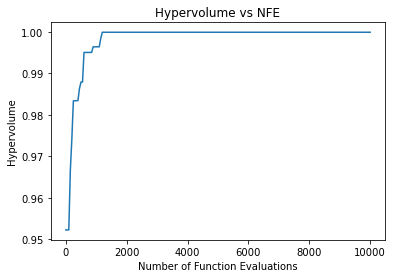

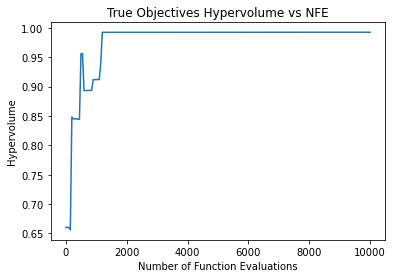

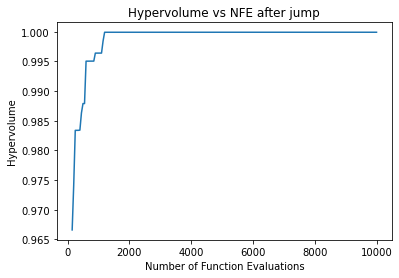

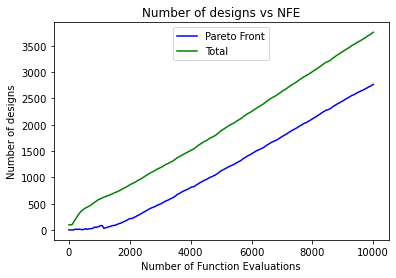

In [9]:
### PLOTTTING FOR PENALIZED OBJECTIVES

print('Plotting')
#### Plot hypervolume vs NFE
fig1 = plt.figure(1)
plt.plot(nfe_array,hypervols)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.title('Hypervolume vs NFE')
plt.show()
#fig1.savefig('HV_plot_eps_truss_' + str(run_number) + '.png')

#### Plot true objectves hypervolume vs NFE
fig1a = plt.figure(1)
plt.plot(nfe_array,hypervols_true)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.title('True Objectives Hypervolume vs NFE')
plt.show()
#fig1a.savefig('HV_plot_eps_truss_' + str(run_number) + '.png')

#### Plot hypervolume vs NFE after hypervolume jump
fig2 = plt.figure(1)
plt.plot(nfe_array_after_jump,hypervols_after_jump)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.title('Hypervolume vs NFE after jump')
plt.show()
#fig2.savefig('HV_plot_post_jump_eps_truss_' + str(run_number) + '.png')

#### Plot number of designs in the pareto front vs NFE
fig3 = plt.figure(2)
plt.plot(nfe_array,n_pareto_all_archs,'b-',label='Pareto Front')
plt.plot(nfe_array,n_total_archs,'g-',label='Total')
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Number of designs')
plt.title('Number of designs vs NFE')
plt.legend(loc='upper center')
plt.show()
#fig3.savefig('num_designs_vs_nfe_eps_truss_' + str(run_number) + '.png')

In [ ]:
### TRUE OBJECTIVES HYPERVOLUME COMPUTATION

def rectify_objectives_true(objs1_sorted, objs2_sorted, num_evals_list, val, true_obj1_max_overall, true_obj1_min_overall, true_obj2_max_overall, true_obj2_min_overall):
    objs = []
    objs_true = []
    #print(val)
    if val==0.0:
        n_eval_ind_last = find_last_index2(val, num_evals_list)
    else:
        n_eval_ind_last = find_closest_index(val, num_evals_list)
    
    #print('n_eval_ind_last = ' + str(n_eval_ind_last))
    
    obj1_current = objs1_sorted[:n_eval_ind_last]
    obj2_current = objs2_sorted[:n_eval_ind_last]
    n_total = len(obj1_current)
    
    obj2_current_pf = np.multiply(obj2_current,-1)
    
    ## Determining the pareto front from the current population
    pop_current = list(zip(obj1_current,obj2_current_pf))
    pareto_current = compute_pareto_front(pop_current)
    pareto_current_unique = list(set(pareto_current))
    print('pareto front of the current population')
    print(pareto_current_unique)
    feas_array_pareto = []
    stab_array_pareto = []
    true_obj_pareto = []
    designs_pareto = []
    for pareto_obj_array in pareto_current_unique:
        pareto_index = objs1_sorted.index(pareto_obj_array[0])
        #pareto_index2 = objs2_sorted.index(pareto_obj_array[1])
        #print('pareto_indices')
        #print(pareto_index)
        #print(pareto_index2)
        feas_pareto = get_feasibility_score(feas_scores_sorted, pareto_index)
        stab_pareto = get_stability_score(stab_scores_sorted, pareto_index)
        feas_array_pareto.append(feas_pareto)
        stab_array_pareto.append(stab_pareto)
        #print(pareto_obj_array)
        #print(feas_pareto)
        #print(stab_pareto)
        
        designs_pareto.append(get_design(designs_sorted, pareto_index))
    print('feasibility score(s)')
    print(feas_array_pareto)
    print('stability score(s)')
    print(stab_array_pareto)
    print('designs')
    print(designs_pareto)
        
    ## Normalizing both objectives, second true objective is to be maximized thus the smallest value is assigned normalized score of 1
    n_pareto_all = len(pareto_current)
    n_pareto = len(pareto_current_unique)
    obj1_pareto = [objs[0] for objs in pareto_current_unique]
    obj2_pareto = [-objs[1] for objs in pareto_current_unique]
    
    obj1_rectified = np.zeros(n_pareto)
    obj2_rectified = np.zeros(n_pareto)
    
    for i in range(n_pareto):
        obj1_rectified[i] = (obj1_pareto[i] - true_obj1_min_overall)/(true_obj1_max_overall - true_obj1_min_overall)
        obj2_rectified[i] = (true_obj2_max_overall - obj2_pareto[i])/(true_obj2_max_overall - true_obj2_min_overall)
        objs.insert(i, [obj1_rectified[i], obj2_rectified[i]])
        
    obj1_rect_list = list(obj1_rectified)
    obj2_rect_list = list(obj2_rectified)
    
    #print('Normalized Objectives')
    #print(obj1_rect_list)
    #print(obj2_rect_list)
    
    return objs, n_pareto, n_pareto_all, n_total

print('Starting hypervolume computation for true objectives')
pop_size = int(find_last_index2(0, nfe_list_sorted))
n_iter_jump = 50
n_iter = math.floor(max_func_evals/n_iter_jump)
hypervols_true = np.zeros(n_iter+1)
nfe_array = np.zeros(n_iter+1)
n_pareto_archs_true = np.zeros(n_iter+1)
n_pareto_all_archs_true = np.zeros(n_iter+1)
n_total_archs_true = np.zeros(n_iter+1)
objs0, n_pareto_0, n_pareto_all_0, n_total_0 = rectify_objectives_true(true_obj1_sorted, true_obj2_sorted, nfe_list_sorted, 0.0, true_obj1_max_fullrun, true_obj1_min_fullrun, true_obj2_max_fullrun, true_obj2_min_fullrun)
n_pareto_archs_true[0] = n_pareto_0
n_pareto_all_archs_true[0] = n_pareto_all_0
n_total_archs_true[0] = n_total_0
hv = hypervolume(objs0)
hypervols_true[0] = hv.compute(ref_point)/1.1**2
print('hypervolume')
print(hypervols_true[0])
print('\n')
objs = [] 

print('Starting loop')
count = 1
for i in range(pop_size, int(max_func_evals), n_iter_jump):
    #n_eval_ind_last = find_last_index(math.floor((max_func_evals/10)*(i)), nfe_list)
    #print('iter = ' + str(i))
    
    objs_i, n_pareto_i, n_pareto_all_i, n_total_i = rectify_objectives_true(true_obj1_sorted, true_obj2_sorted, nfe_list_sorted, i, true_obj1_max_fullrun, true_obj1_min_fullrun, true_obj2_max_fullrun, true_obj2_min_fullrun)
    print('hypervolume objectives')
    print(objs_i)
    n_pareto_archs_true[count] = n_pareto_i
    n_total_archs_true[count] = n_total_i
    n_pareto_all_archs_true[count] = n_pareto_all_i
    hv = hypervolume(objs_i)
    hypervols_true[count] = hv.compute(ref_point)/1.1**2
    print('hypervolume')
    print(hypervols_true[count])
    print('\n')
    nfe_array[count] = i
    count += 1
    
objs_last, n_pareto_last, n_pareto_all_last, n_total_last = rectify_objectives_true(true_obj1_sorted, true_obj2_sorted, nfe_list_sorted, max_func_evals, true_obj1_max_fullrun, true_obj1_min_fullrun, true_obj2_max_fullrun, true_obj2_min_fullrun)
n_pareto_archs_true[-1] = n_pareto_last
n_pareto_all_archs_true[-1] = n_pareto_all_last
n_total_archs_true[-1] = n_total_last
hv = hypervolume(objs_last)
hypervols_true[-1] = hv.compute(ref_point)/1.1**2
print('hypervolume')
print(hypervols_true[-1])
print('\n')
nfe_array[-1] = max_func_evals

In [ ]:
### PLOTTTING FOR TRUE OBJECTIVES

print('Plotting')
#### Plot hypervolume vs NFE
fig4 = plt.figure(1)
plt.plot(nfe_array,hypervols_true)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.title('Hypervolume vs NFE')
plt.show()
#fig4.savefig('HV_plot_eps_truss_' + str(run_number) + '.png')

#### Plot number of designs in the pareto front vs NFE
fig5 = plt.figure(2)
plt.plot(nfe_array,n_pareto_all_archs_true,'b-',label='Pareto Front')
plt.plot(nfe_array,n_total_archs_true,'g-',label='Total')
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Number of designs')
plt.title('Number of designs vs NFE')
plt.legend(loc='upper center')
plt.show()
#fig5.savefig('num_designs_vs_nfe_eps_truss_' + str(run_number) + '.png')

In [ ]:
np.max(hypervols)

In [ ]:
feas_score = 0.40000000000000013
stab_score = 0.7000000000000001
pen_objective_1 = 0.45102622364079553
pen_objective_2 = -0.3209040150315412
pen_fac = 1.5
pen = (np.log10(np.absolute(feas_score)) + np.log10(np.absolute(stab_score)))/2
obj1 = 15*(pen_objective_1 + pen_fac*pen)
obj2 = -8500*(pen_objective_2 + pen_fac*pen)
print(obj1)
print(obj2)